In [2]:
# Cell 1: Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

def load_and_preprocess(path="../data/creditcard.csv"):
    df = pd.read_csv(path)
    X = df.drop("Class", axis=1)
    y = df["Class"]

    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)

    return train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)


In [10]:
# -------------------------
# Step 4: Modeling
# -------------------------

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report
from tqdm import tqdm  # progress bar

print(" Training Models...\n")

# Logistic Regression (faster settings)
print(" Training Logistic Regression...")
lr = LogisticRegression(
    solver="liblinear",      # faster, good for binary
    max_iter=200,            # reduced iterations
    class_weight="balanced", # handle imbalance
    n_jobs=-1
)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(" Logistic Regression Done!\n")
print(classification_report(y_test, y_pred_lr))

# Random Forest
print(" Training Random Forest...")
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(" Random Forest Done!\n")
print(classification_report(y_test, y_pred_rf))

# Isolation Forest (anomaly detection)
print(" Training Isolation Forest...")
iso = IsolationForest(
    contamination=0.001, # approx fraud ratio
    random_state=42,
    n_jobs=-1
)
iso.fit(X_train)
y_pred_iso = iso.predict(X_test)
# Isolation Forest returns -1 for fraud, 1 for normal
y_pred_iso = [1 if p == -1 else 0 for p in y_pred_iso]
print(" Isolation Forest Done!\n")
print(classification_report(y_test, y_pred_iso))


 Training Models...

 Training Logistic Regression...


c:\Users\FR4001TU\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


 Logistic Regression Done!

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     56863
           1       0.98      0.95      0.96     56863

    accuracy                           0.97    113726
   macro avg       0.97      0.97      0.97    113726
weighted avg       0.97      0.97      0.97    113726

 Training Random Forest...
 Random Forest Done!

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

 Training Isolation Forest...
 Isolation Forest Done!

              precision    recall  f1-score   support

           0       0.50      1.00      0.67     56863
           1       0.98      0.00      0.00     56863

    accuracy                           0.50    113

📊 Comparing Models...

Logistic Regression: ROC-AUC = 0.9652
Random Forest: ROC-AUC = 0.9998
Isolation Forest: ROC-AUC = 0.5010


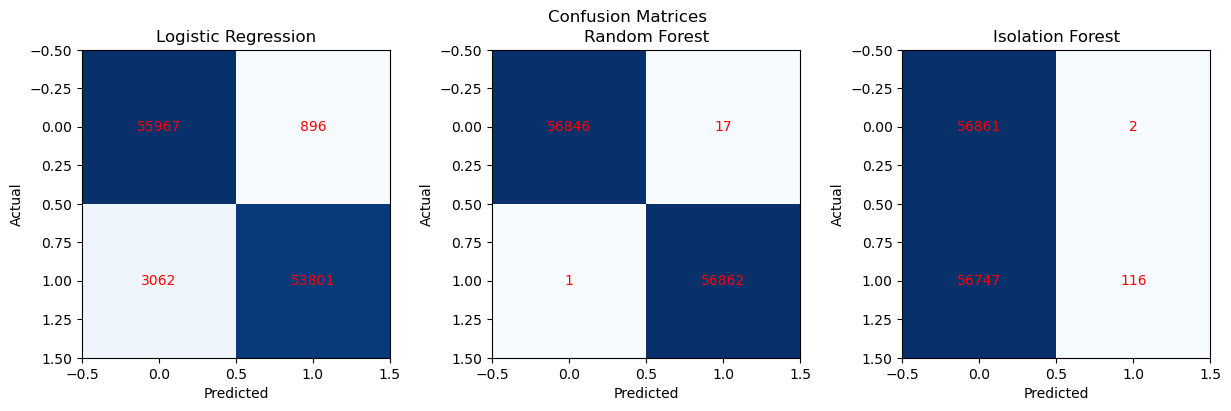

<Figure size 600x500 with 0 Axes>

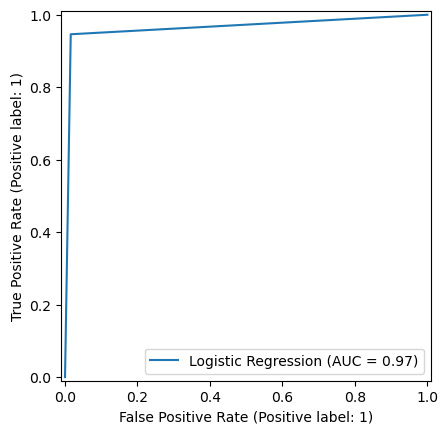

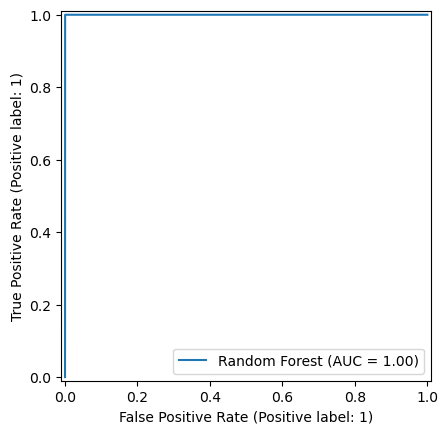

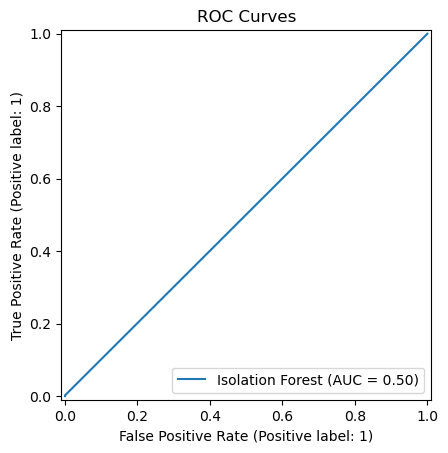

In [11]:
# -------------------------
# Step 5: Model Evaluation & Comparison
# -------------------------

from sklearn.metrics import confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

print("📊 Comparing Models...\n")

# Store results in a dictionary
results = {
    "Logistic Regression": {
        "y_pred": y_pred_lr,
        "roc_auc": roc_auc_score(y_test, y_pred_lr)
    },
    "Random Forest": {
        "y_pred": y_pred_rf,
        "roc_auc": roc_auc_score(y_test, y_pred_rf)
    },
    "Isolation Forest": {
        "y_pred": y_pred_iso,
        "roc_auc": roc_auc_score(y_test, y_pred_iso)
    }
}

# Print AUC scores
for model, metrics in results.items():
    print(f"{model}: ROC-AUC = {metrics['roc_auc']:.4f}")

# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (model, metrics) in zip(axes, results.items()):
    cm = confusion_matrix(y_test, metrics["y_pred"])
    ax.imshow(cm, cmap="Blues")
    ax.set_title(model)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="red")
plt.suptitle("Confusion Matrices")
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
for model, metrics in results.items():
    RocCurveDisplay.from_predictions(y_test, metrics["y_pred"], name=model)
plt.title("ROC Curves")
plt.show()


In [12]:
import pickle

# Save Random Forest model (you can also save Logistic Regression, etc.)
with open("rf_model.pkl", "wb") as f:
    pickle.dump(rf, f)


In [13]:
import joblib

# Save model inside models/ folder
import os
os.makedirs("models", exist_ok=True)
joblib.dump(rf, "models/rf.joblib")


['models/rf.joblib']